In [2]:
%load_ext autoreload
%autoreload 2

from synchronization import plots
from synchronization.experiments import IndependentNoiseOn2CoupledNetworks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Effect of uncorrelated noise on coupled EI networks

Hypothesis
* in certain parameter regimes the EI networks synchronize while within synchronization decreases
* only a fraction of the neurons in a network spike in each cycle, we see a widened voltage distribution

Setup
* 2 coupled network case
* independent noise with varying strengths

Metrics & Visualization
* overlap in peak frequency in power spectrum indicates synchronization
* local and global order parameter quantify synchronization respectively
* optional: mean phase coherence

Run for different noise strenghts and plot PSD spectra of all runs.
A handful of parameter sets should suffice to get a first intuition. Afterwards we can do an exhaustive parameter exploration.

In [3]:
exp = IndependentNoiseOn2CoupledNetworks()

In [4]:
exp.clean()
exp.run()

Start cleaning models of experiment ind_noise_coupled_network
Remove file /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ind_noise_coupled_network/1.7.pkl
Remove file /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ind_noise_coupled_network/1.4.pkl
Remove file /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ind_noise_coupled_network/0.5.pkl
Remove file /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ind_noise_coupled_network/0.2.pkl
Remove file /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ind_noise_coupled_network/0.8.pkl
Remove file /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models/ind_noise_coupled_network/1.0999999999999999.pkl
Finished cleaning.
Cleaning previous run ...
Start cleaning models of experiment ind_noise_coupled_network
Finished cleaning.
Starting with new run ...
1 of [0.2 0.5 0.8 1.1 1.4 1.7] Running parameter configuration: 0.2 ...
Initializing net ...
Initia

In [5]:
models = exp.load()
print(len(models))

6


Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...


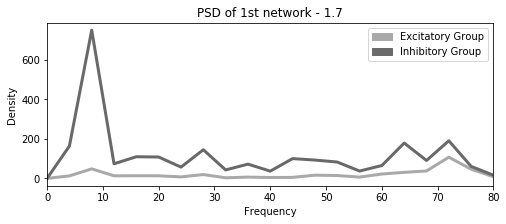

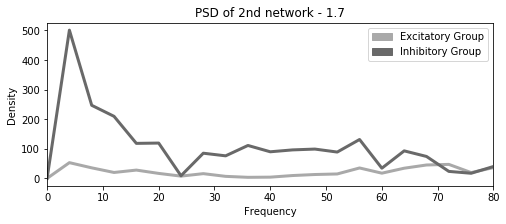

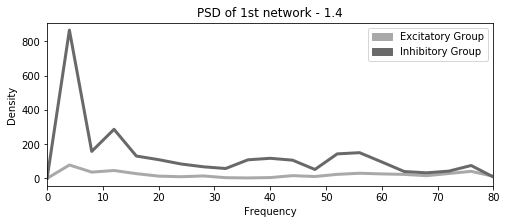

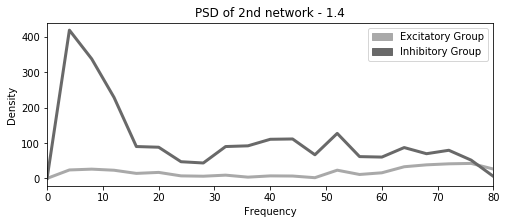

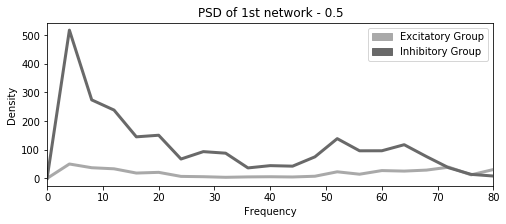

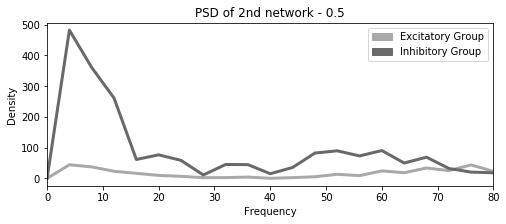

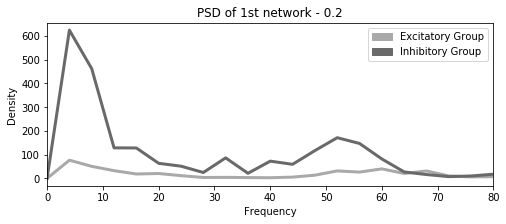

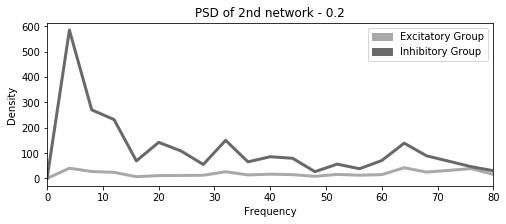

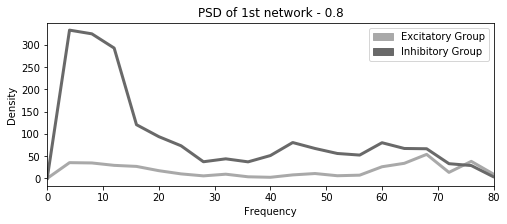

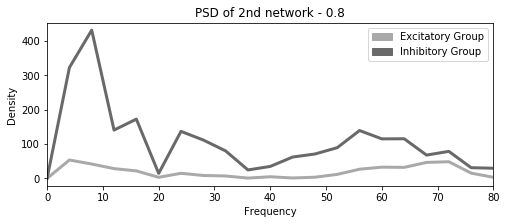

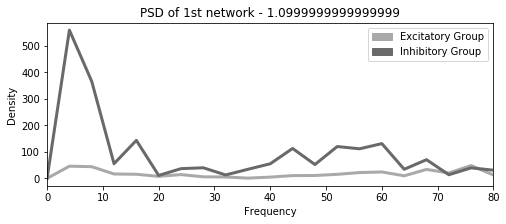

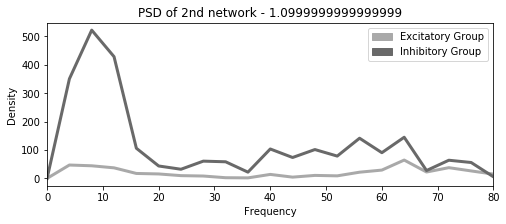

In [6]:
# TODOs:
# * Improve PSD plotting
# * calculate global and local order parameter for each run
# * compare coupled state with uncoupled state, uncoupled state acts as control group
# * with current EI network parameters we get a very scattered power spectrum, adjust parameters so that we get 1-3 main peaks in gamma band only.

for model in models:
    strength = model["params"]["poisson_strengths"][0]
    plots.psd(model, title=f"PSD of 1st network - {strength}", population=1)
    plots.psd(model, title=f"PSD of 2nd network - {strength}", population=2)


In [7]:
from synchronization.experiments import MopetExampleExperiment

MopetExampleExperiment().run()

2020-05-27 15:54:19,306	INFO resource_spec.py:212 -- Starting Ray with 9.57 GiB memory available for workers and up to 4.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-27 15:54:19,666	INFO services.py:1170 -- View the Ray dashboard at localhost:8265
  0%|          | 0/2 [00:00<?, ?it/s](pid=34403) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
(pid=34403) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out
(pid=34401) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
(pid=34401) /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out
(pid=34403) Initializing net ...
(pid=34401) Initializing net ...
(pid=34403) Initialization time: 0.19313478469848633s
(pid=34403) ==== Running Network ... ====
(pid=34401) Initialization time: 0.19019222259521484s
(pid=34401) ==== Running Network ... ====
(pid=34401) WARNING    Note that the synaptic pathway 'synapses_1_p